# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid.inset_locator import inset_axes
%matplotlib notebook

import re
from scipy.integrate import odeint, solve_ivp

# Decalaring Paths

In [3]:
results_path = '../Notebook Results/Chapter 1/'

# Initializations

In [4]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [5]:
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.figsize'] = (10,5)

# Pendulum Simulation

**Pendulum**

\begin{equation}
\begin{aligned}
F = ma &\Leftrightarrow m\frac{d^2 \theta}{d x^2} \\
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
x_{displacement} &= L\theta\\ \\ \\
\end{aligned}
\end{equation}

\begin{aligned}
m\frac{d^2 x}{d x^2} &= mgsin(\theta) - \mu\omega \\
m\frac{d^2 (L\theta)}{d x^2} &= mgsin(\theta) - \mu\omega \\
mL\frac{d^2 (\theta)}{d x^2} &= mgsin(\theta) - \mu\omega \\
\frac{d^2 (\theta)}{d x^2} &= \frac{g}{L}sin(\theta) - \frac{\mu}{mL}\omega \\
\frac{d^2 (\theta)}{d x^2} &= \frac{g}{L}sin(\theta) - \frac{\mu}{mL}\frac{d (\theta)}{d x} \\
\end{aligned}


In [7]:
class PendulumSimulator:
    
    def __init__(self, theta_0 = 60.0, omega_0 = 3.9, air_resistance_factor = 0.01, 
                 gravitational_force = 9.8, length = 2, timesteps = 1000, vector_skips=5, interval=50):
        self.DEGREES = np.pi/180
        self.theta_0 = theta_0*self.DEGREES
        self.omega_0 = omega_0
        self.air_resistance_factor = air_resistance_factor
        self.gravitational_force = gravitational_force
        self.length = length
        self.timesteps = timesteps
        self.simulation_time = np.linspace(0, self.timesteps, 10*(self.timesteps)+1)
        self.labels_changed = False
        self.vector_skips = vector_skips
        self.interval = interval
        
    @staticmethod
    def get_pendulum_deriv(t, params, g, l, a):
        _theta = params[0]
        _omega = params[1]
        d_theta = _omega
        d_omega = -(g/l)*np.sin(_theta) - (a*d_theta)
        return d_theta, d_omega
    
    @staticmethod
    def update_rad2deg(labels):
        _labels = [float(re.sub(r'[^\x00-\x7F]+','-', s)) for s in labels]
        _labels = [round((int(k)*(180/np.pi))/180, 1) for k in _labels]
        _labels = [r'${0}\pi$'.format(k) for k in _labels]
        return _labels

    def calculate_deriv(self):
        
        y0 = [self.theta_0, self.omega_0]
        res = odeint(self.get_pendulum_deriv, y0, self.simulation_time,
                     args=(self.gravitational_force, self.length,self.air_resistance_factor), 
                     tfirst=True)
        self._theta, self._omega = res.T
        self._alpha = -(self.gravitational_force/self.length)*np.sin(self._theta) - (self.air_resistance_factor*self._omega)
        self.pendulum_coord = self.length*np.c_[np.cos((1.5*np.pi)+self._theta),
                                                np.sin((1.5*np.pi)+self._theta)]
        
    def init_plot(self):
        
        self.axes.set_title(r'$Dynamic Of A Pendulum$')
        self.ot_axes = inset_axes(self.axes, width="40%", height="30%", loc=4,
                                  bbox_to_anchor=(0,0.1,1,1), bbox_transform=self.axes.transAxes)
        self.ot_axes.patch.set_alpha(0.5)
        self.pen_axes = inset_axes(self.axes, width="15%", height="30%", loc=3,
                                   bbox_to_anchor=(0.055,0.1,1,1), bbox_transform=self.axes.transAxes)
        self.pen_axes.patch.set_alpha(0.5)
        
        # Setup Time v/s Theta Axes
        self._p1, = self.axes.plot(self.simulation_time[0], self._theta[0], marker = 'o', markersize=1.2, lw=0.1, color='w')
        self._p2, = self.ot_axes.plot(self._theta[0], self._omega[0], color='w', lw=0.8)
        self._p3  = self.ot_axes.scatter(self._theta[0], self._omega[0], facecolor='r', edgecolor='r', s=5)

        self.axes.set_facecolor('k')
        self.axes.grid()
        self.axes.set_xlabel(r'$Time(sec) \longrightarrow$')
        self.axes.set_ylabel(r'$\theta^\circ_{rad} \longrightarrow$')
        self.axes.set_ylim(self._theta.min()*1.1, self._theta.max()*1.1)

        # Setup Omega Theta Axes
        self.ot_axes.set_facecolor('#ffefd6')
        for spine in self.ot_axes.spines.values():
            spine.set_edgecolor('white')

        self.ot_axes.grid(color='w', linestyle='-.', linewidth=0.3)
        _xrange = np.arange(self._theta.min()*1.2,self._theta.max()*1.2)
        _yrange = np.arange(self._omega.min()*1.2,self._omega.max()*1.2)
        self.ot_axes.plot([0]*len(_yrange),_yrange, lw=1, c='w')
        self.ot_axes.plot(_xrange,[0]*len(_xrange), lw=1, c='w')
        self.ot_axes.tick_params(axis='both', colors='w')
        self.ot_axes.set_xlabel(r'$\theta^\circ_{rad} \longrightarrow$', color='w')
        self.ot_axes.set_ylabel(r'$\omega \longrightarrow$', color='w')
        
        skip = slice(None, None, self.vector_skips)
        self.ot_axes.quiver(self._theta[skip], self._omega[skip], self._omega[skip], self._alpha[skip], 
                              color='#cffaac', pivot='tip', width=0.005, scale=1 / 0.015, alpha=0.5)
        
        # Setup Pendulum Axes
        self.pen_axes.text(0, 1.5*self.length, r'$0^\circ$', fontsize=12, color='w')
        self.pen_axes.tick_params(labelbottom = False, labeltop = False,
                                  labelleft = False, labelright = False)
        self.pen_axes.set_xlim(-1.5*self.length,1.5*self.length)
        self.pen_axes.set_ylim(-1.5*self.length,1.5*self.length)
        for spine in self.pen_axes.spines.values():
            spine.set_edgecolor('white')
        self.pen_axes.plot([0]*50, np.arange(-25,25), color='w', lw=0.8, linestyle='-.')
        self.pen_axes.plot(np.arange(-25,25), [0]*50, color='w', lw=0.4, linestyle='-.')
        self.pen_axes.scatter(0, 0, facecolor='k', edgecolor='w', s=3)
        self._p4, = self.pen_axes.plot([0,self.pendulum_coord[0][0]], 
                                       [0,self.pendulum_coord[0][1]],
                                       color='#ffd77a')
        self._p5 = self.pen_axes.scatter(self.pendulum_coord[0][0],
                                         self.pendulum_coord[0][1],
                                         facecolor='brown', edgecolor='w', s=25)
        
        return [self._p1, self._p2, self._p3, self._p4, self._p5]
    
    def update_plot(self, i):
        self.axes.set_xlim(0, self.simulation_time[i])
        
        if self.labels_changed == False:
            actual_labels1 = [k.get_text() for k in self.axes.get_yticklabels()]
            updated_labels1 = self.update_rad2deg(actual_labels1)
            self.axes.set_yticklabels(updated_labels1)

            actual_labels2 = [k.get_text() for k in self.ot_axes.get_xticklabels()]
            updated_labels2 = self.update_rad2deg(actual_labels2)
            self.ot_axes.set_xticklabels(updated_labels2)
            self.labels_changed = True
        
        self._p1.set_data(self.simulation_time[:i], self._theta[:i])
        self._p2.set_data(self._theta[i-10:i], self._omega[i-10:i])
        self._p3.set_offsets(np.c_[self._theta[i-1], self._omega[i-1]])
        self._p4.set_data([0,self.pendulum_coord[i][0]], 
                          [0,self.pendulum_coord[i][1]])
        self._p5.set_offsets(self.pendulum_coord[i])
        
        return [self._p1, self._p2, self._p3, self._p4, self._p5]
    
    def start_simulation(self):
        
        self.fig, self.axes = plt.subplots()
        self.calculate_deriv()
        self.ani=FuncAnimation(fig=self.fig, func=self.update_plot, init_func=self.init_plot,
                               interval=self.interval, blit=True, save_count = 1000)
        plt.show()


<IPython.core.display.Javascript object>


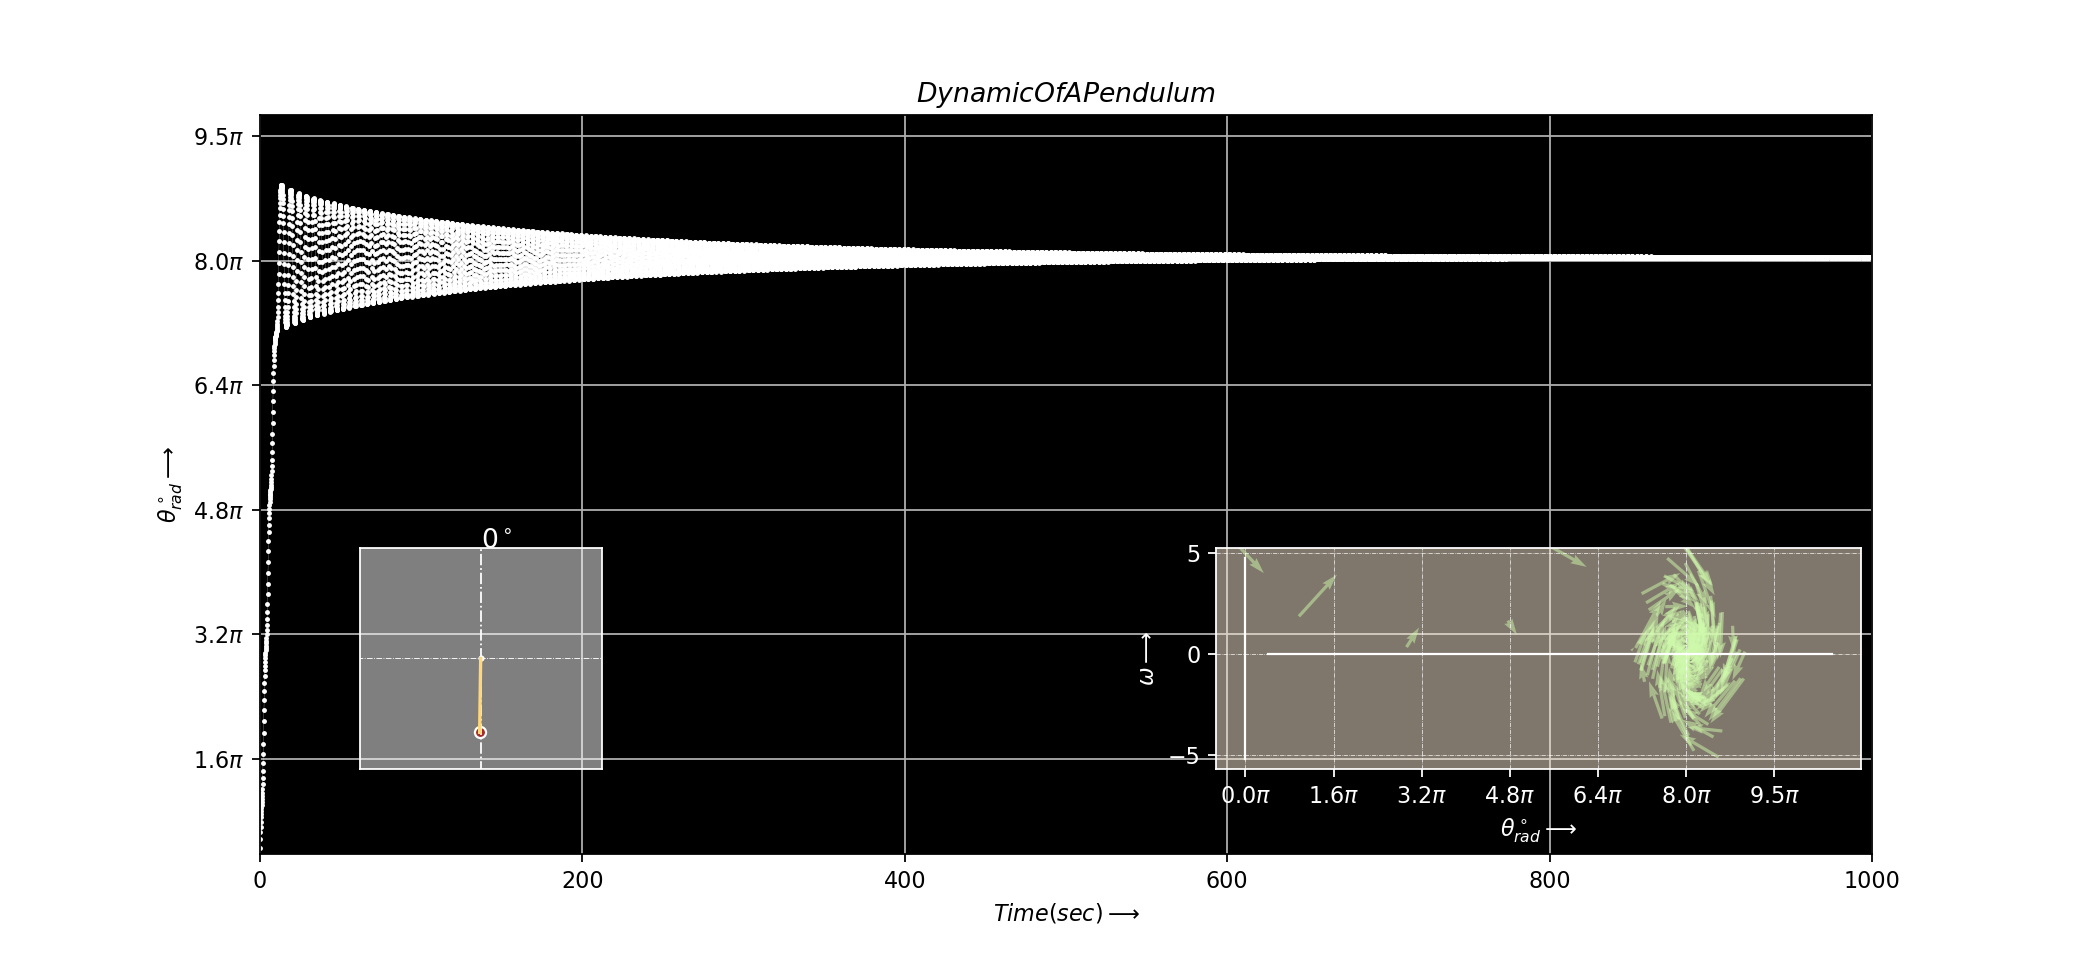

In [8]:
psHandler = PendulumSimulator(theta_0 = 60.0, omega_0 = 4, 
                              air_resistance_factor = 0.01, gravitational_force = 9.8, 
                              length = 2, timesteps = 1000, vector_skips = 20, interval=50)
plt.rcParams['figure.figsize'] = (13,6)
psHandler.start_simulation()